# Clustering

In [1]:
# imports
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
import ipywidgets as widgets
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.pipeline import Pipeline
import xgboost as xgb
import datetime
%matplotlib inline

In [2]:
ladf = gpd.read_file('data/Local_Authority_Districts_(December_2020)_UK_BFC.zip!Local_Authority_Districts_(December_2020)_UK_BFC.shp')
ladf

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.676140,9.371263e+07,71007.443285,"MULTIPOLYGON (((447213.899 537036.104, 447228...."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.388156e+07,44481.691242,"MULTIPOLYGON (((448609.900 521982.600, 448616...."
2,3,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.567520,2.450695e+08,96703.989701,"MULTIPOLYGON (((455932.335 527880.697, 455919...."
3,4,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.556911,2.049330e+08,123408.985928,"MULTIPOLYGON (((444157.002 527956.304, 444165...."
4,5,E06000005,Darlington,None,428029,515648,-1.56835,54.535339,1.974757e+08,107206.401677,"POLYGON ((423496.602 524724.299, 423497.204 52..."
...,...,...,...,...,...,...,...,...,...,...,...
374,375,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.698360,1.262399e+08,82544.775967,"POLYGON ((323898.201 211287.499, 324115.698 21..."
375,376,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.778271,8.503266e+08,224917.251559,"MULTIPOLYGON (((327830.799 231005.105, 327840...."
376,377,W06000022,Newport,Casnewydd,337897,187432,-2.89769,51.582310,1.904311e+08,153216.416923,"MULTIPOLYGON (((342211.900 194845.495, 342221...."
377,378,W06000023,Powys,Powys,302329,273255,-3.43531,52.348640,5.195311e+09,610132.027463,"POLYGON ((322392.901 334017.198, 322378.002 33..."


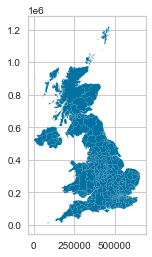

In [3]:
# using https://geopandas.org/en/v0.8.2/mapping.html
ladf.plot()
plt.show()

In [4]:
# get the case data
cases_df = pd.read_csv('data/ltla_caseData.csv')
cases_df.date = pd.to_datetime(cases_df['date'])
cases_df.head()

,areaCode,areaName,areaType,date,newCasesByPublishDate,newDeaths28DaysByDeathDate,newPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate
0,E06000003,Redcar and Cleveland,ltla,2021-12-28,238.0,NaN,NaN,NaN
1,E07000040,East Devon,ltla,2021-12-28,243.0,NaN,NaN,NaN
2,E07000090,Havant,ltla,2021-12-28,232.0,NaN,NaN,NaN
3,E07000214,Surrey Heath,ltla,2021-12-28,154.0,NaN,NaN,NaN
4,E07000229,Worthing,ltla,2021-12-28,167.0,NaN,NaN,NaN


In [5]:
# get the census data
census_df = pd.read_csv("districtCensusData.csv")
census_df.head()

,geography,geography_code,dwelling_type_all_categories_accommodation_type,dwelling_type_unshared_dwelling_total,dwelling_type_unshared_dwelling_whole_house_or_bungalow_total,dwelling_type_unshared_dwelling_whole_house_or_bungalow_detached,dwelling_type_unshared_dwelling_whole_house_or_bungalow_semi-detached,dwelling_type_unshared_dwelling_whole_house_or_bungalow_terraced_(including_end-terrace),dwelling_type_unshared_dwelling_flat_maisonette_or_apartment_total,dwelling_type_unshared_dwelling_flat_maisonette_or_apartment_purpose-built_block_of_flats_or_tenement,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
0,Darlington,E06000005,104111.0,103979.0,95581.0,20750.0,42278,32553,8334.0,6748,...,862,3430.0,441,193,30531.0,3400.0,1170,6625,309.0,27621.0
1,County Durham,E06000047,500288.0,500209.0,481791.0,108279.0,187338,186174,17940.0,13491,...,1948,13963.0,1521,1061,154210.0,17707.0,2243,23797,1471.0,155902.0
2,Hartlepool,E06000001,91091.0,91063.0,84220.0,17724.0,31926,34570,6703.0,5739,...,481,2592.0,700,180,23871.0,3214.0,723,4514,414.0,29037.0
3,Middlesbrough,E06000002,136156.0,135987.0,125261.0,21120.0,58589,45552,10687.0,8972,...,718,4975.0,957,197,32508.0,4745.0,1397,7063,637.0,46004.0
4,Northumberland,E06000057,310591.0,310554.0,288741.0,86610.0,116600,85531,21362.0,16260,...,1952,7711.0,588,704,96053.0,9552.0,2137,16924,1411.0,86323.0


In [6]:
# merge the geographic and census data
df = ladf.merge(census_df, how='outer', left_on='LAD20CD', right_on='geography_code')
df.head()

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
0,1.0,E06000001,Hartlepool,None,447160.0,531474.0,-1.27018,54.676140,9.371263e+07,71007.443285,...,481.0,2592.0,700.0,180.0,23871.0,3214.0,723.0,4514.0,414.0,29037.0
1,2.0,E06000002,Middlesbrough,None,451141.0,516887.0,-1.21099,54.544670,5.388156e+07,44481.691242,...,718.0,4975.0,957.0,197.0,32508.0,4745.0,1397.0,7063.0,637.0,46004.0
2,3.0,E06000003,Redcar and Cleveland,None,464361.0,519597.0,-1.00608,54.567520,2.450695e+08,96703.989701,...,1193.0,3372.0,414.0,259.0,37919.0,4054.0,894.0,5731.0,733.0,42823.0
3,4.0,E06000004,Stockton-on-Tees,None,444940.0,518183.0,-1.30664,54.556911,2.049330e+08,123408.985928,...,1166.0,5115.0,642.0,417.0,60422.0,6160.0,1715.0,7518.0,1018.0,53532.0
4,5.0,E06000005,Darlington,None,428029.0,515648.0,-1.56835,54.535339,1.974757e+08,107206.401677,...,862.0,3430.0,441.0,193.0,30531.0,3400.0,1170.0,6625.0,309.0,27621.0


<AxesSubplot:>

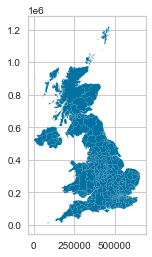

In [7]:
df.plot()

In [8]:
# find na data
df.isna().sum()

OBJECTID                                                     9
LAD20CD                                                      9
LAD20NM                                                      9
LAD20NMW                                                   366
BNG_E                                                        9
                                                          ... 
method_of_travel_to_work_passenger_in_a_car_or_van          45
method_of_travel_to_work_bicycle                            45
method_of_travel_to_work_on_foot                            45
method_of_travel_to_work_other_method_of_travel_to_work     45
method_of_travel_to_work_not_in_employment                  45
Length: 106, dtype: int64

In [9]:
# census data missing geography
df[df['LAD20NM'].isnull()][['geography_code','geography']]

,geography_code,geography
379,E07000201,Forest Heath
380,E07000204,St Edmundsbury
381,E07000206,Waveney
382,E07000004,Aylesbury Vale
383,E07000005,Chiltern
384,E07000006,South Bucks
385,E07000007,Wycombe
386,E07000051,Purbeck
387,E07000053,Weymouth and Portland


In [10]:
# geography missing census data
df[df['geography_code'].isnull() & ((df['LAD20CD'].str.startswith('E')) | (df['LAD20CD'].str.startswith('W')))]

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
49,50.0,E06000053,Isles of Scilly,None,91327.0,11447.0,-6.30217,49.923321,1.631775e+07,117979.580176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,57.0,E06000060,Buckinghamshire,None,482506.0,208561.0,-0.80569,51.769661,1.564949e+09,361853.598103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# create buckinghamshire data
census_bucks = census_df[census_df['geography_code'].isin(['E07000004', 'E07000005', 'E07000006', 'E07000007'])].sum()
census_bucks['geography'] = 'Buckinghamshire'
census_bucks['geography_code'] = 'E06000060'
#census_bucks.tolist()

# reset the dataframe
census_df = pd.read_csv("districtCensusData.csv")
census_df.loc[344] = census_bucks
#census_df.index = census_df.index + 1
# drop the counties
census_df.drop(census_df[census_df['geography_code'].isin(['E07000004', 'E07000005', 'E07000006', 'E07000007'])].index, inplace=True)
census_df

,geography,geography_code,dwelling_type_all_categories_accommodation_type,dwelling_type_unshared_dwelling_total,dwelling_type_unshared_dwelling_whole_house_or_bungalow_total,dwelling_type_unshared_dwelling_whole_house_or_bungalow_detached,dwelling_type_unshared_dwelling_whole_house_or_bungalow_semi-detached,dwelling_type_unshared_dwelling_whole_house_or_bungalow_terraced_(including_end-terrace),dwelling_type_unshared_dwelling_flat_maisonette_or_apartment_total,dwelling_type_unshared_dwelling_flat_maisonette_or_apartment_purpose-built_block_of_flats_or_tenement,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
0,Darlington,E06000005,104111.0,103979.0,95581.0,20750.0,42278,32553,8334.0,6748,...,862,3430.0,441,193,30531.0,3400.0,1170,6625,309.0,27621.0
1,County Durham,E06000047,500288.0,500209.0,481791.0,108279.0,187338,186174,17940.0,13491,...,1948,13963.0,1521,1061,154210.0,17707.0,2243,23797,1471.0,155902.0
2,Hartlepool,E06000001,91091.0,91063.0,84220.0,17724.0,31926,34570,6703.0,5739,...,481,2592.0,700,180,23871.0,3214.0,723,4514,414.0,29037.0
3,Middlesbrough,E06000002,136156.0,135987.0,125261.0,21120.0,58589,45552,10687.0,8972,...,718,4975.0,957,197,32508.0,4745.0,1397,7063,637.0,46004.0
4,Northumberland,E06000057,310591.0,310554.0,288741.0,86610.0,116600,85531,21362.0,16260,...,1952,7711.0,588,704,96053.0,9552.0,2137,16924,1411.0,86323.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,East Suffolk,E07000244,60895.5,60847.5,56914.5,28714.5,18546,9654,3591.5,2623,...,628,702.5,68,324,19449.5,1246.5,1356,2795,171.5,14996.5
340,West Suffolk,E07000245,60895.5,60847.5,56914.5,28714.5,18546,9654,3591.5,2623,...,628,702.5,68,324,19449.5,1246.5,1356,2795,171.5,14996.5
341,"Bournemouth, Christchurch and Poole",E06000058,371539.0,368979.0,268020.0,150964.0,75547,41509,100118.0,69998,...,3160,12393.0,548,2300,112191.0,9267.0,8702,20906,1239.0,95414.0
342,Cornwall,E06000052,525555.0,525021.0,474629.0,208536.0,143082,123011,44978.0,29764,...,2464,5961.0,743,2909,157998.0,12931.0,4159,34619,2472.0,144642.0


In [12]:
df = ladf.merge(census_df, how='outer', left_on='LAD20CD', right_on='geography_code')
df

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,method_of_travel_to_work_train,method_of_travel_to_work_bus_minibus_or_coach,method_of_travel_to_work_taxi,method_of_travel_to_work_motorcycle_scooter_or_moped,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment
0,1.0,E06000001,Hartlepool,None,447160.0,531474.0,-1.27018,54.676140,9.371263e+07,71007.443285,...,481.0,2592.0,700.0,180.0,23871.0,3214.0,723.0,4514.0,414.0,29037.0
1,2.0,E06000002,Middlesbrough,None,451141.0,516887.0,-1.21099,54.544670,5.388156e+07,44481.691242,...,718.0,4975.0,957.0,197.0,32508.0,4745.0,1397.0,7063.0,637.0,46004.0
2,3.0,E06000003,Redcar and Cleveland,None,464361.0,519597.0,-1.00608,54.567520,2.450695e+08,96703.989701,...,1193.0,3372.0,414.0,259.0,37919.0,4054.0,894.0,5731.0,733.0,42823.0
3,4.0,E06000004,Stockton-on-Tees,None,444940.0,518183.0,-1.30664,54.556911,2.049330e+08,123408.985928,...,1166.0,5115.0,642.0,417.0,60422.0,6160.0,1715.0,7518.0,1018.0,53532.0
4,5.0,E06000005,Darlington,None,428029.0,515648.0,-1.56835,54.535339,1.974757e+08,107206.401677,...,862.0,3430.0,441.0,193.0,30531.0,3400.0,1170.0,6625.0,309.0,27621.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,253.0,574.0,121.0,235.0,22429.0,1844.0,1156.0,3299.0,168.0,12513.0
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,623.0,1409.0,291.0,400.0,37339.0,3268.0,1740.0,7845.0,283.0,24485.0
381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,548.0,1317.0,252.0,567.0,31732.0,2676.0,3048.0,5629.0,827.0,32696.0
382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,419.0,390.0,42.0,285.0,13900.0,1036.0,634.0,2808.0,182.0,10960.0


In [13]:
# some up the cases
cases_sum = cases_df.groupby('areaCode').sum()

# merge the buckinghamshire cases and drop them
cases_bucks = cases_sum[cases_sum.index.isin(['E07000004', 'E07000005', 'E07000006', 'E07000007'])].sum()
cases_sum.loc['E06000060'] = cases_bucks
cases_sum.drop(['E07000004', 'E07000005', 'E07000006', 'E07000007'], inplace=True)
cases_sum

,newCasesByPublishDate,newDeaths28DaysByDeathDate,newPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate
areaCode,,,,
E06000001,19707.0,292.0,69298.0,63764.0
E06000002,29779.0,393.0,103706.0,93951.0
E06000003,27090.0,358.0,106165.0,98606.0
E06000004,39997.0,508.0,149248.0,136953.0
E06000005,21159.0,294.0,83417.0,76876.0
...,...,...,...,...
W06000021,24981.0,0.0,0.0,0.0
W06000022,53944.0,0.0,0.0,0.0
W06000023,32448.0,0.0,0.0,0.0


In [14]:
# join df and cases_sum
df = df.merge(cases_sum, how='outer', left_on='LAD20CD', right_on=cases_sum.index)
df

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,method_of_travel_to_work_driving_a_car_or_van,method_of_travel_to_work_passenger_in_a_car_or_van,method_of_travel_to_work_bicycle,method_of_travel_to_work_on_foot,method_of_travel_to_work_other_method_of_travel_to_work,method_of_travel_to_work_not_in_employment,newCasesByPublishDate,newDeaths28DaysByDeathDate,newPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate
0,1.0,E06000001,Hartlepool,None,447160.0,531474.0,-1.27018,54.676140,9.371263e+07,71007.443285,...,23871.0,3214.0,723.0,4514.0,414.0,29037.0,19707.0,292.0,69298.0,63764.0
1,2.0,E06000002,Middlesbrough,None,451141.0,516887.0,-1.21099,54.544670,5.388156e+07,44481.691242,...,32508.0,4745.0,1397.0,7063.0,637.0,46004.0,29779.0,393.0,103706.0,93951.0
2,3.0,E06000003,Redcar and Cleveland,None,464361.0,519597.0,-1.00608,54.567520,2.450695e+08,96703.989701,...,37919.0,4054.0,894.0,5731.0,733.0,42823.0,27090.0,358.0,106165.0,98606.0
3,4.0,E06000004,Stockton-on-Tees,None,444940.0,518183.0,-1.30664,54.556911,2.049330e+08,123408.985928,...,60422.0,6160.0,1715.0,7518.0,1018.0,53532.0,39997.0,508.0,149248.0,136953.0
4,5.0,E06000005,Darlington,None,428029.0,515648.0,-1.56835,54.535339,1.974757e+08,107206.401677,...,30531.0,3400.0,1170.0,6625.0,309.0,27621.0,21159.0,294.0,83417.0,76876.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22429.0,1844.0,1156.0,3299.0,168.0,12513.0,NaN,NaN,NaN,NaN
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37339.0,3268.0,1740.0,7845.0,283.0,24485.0,NaN,NaN,NaN,NaN
381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31732.0,2676.0,3048.0,5629.0,827.0,32696.0,NaN,NaN,NaN,NaN
382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13900.0,1036.0,634.0,2808.0,182.0,10960.0,NaN,NaN,NaN,NaN


## Look for interactions

In [ ]:
cols = census_df.columns.to_list()[2:]
# relative cases
df['relativeCases'] = df['newCasesByPublishDate'] / (df['00_59'] + df['60+'])

In [36]:
@widgets.interact(run_graphs=False, sel_col=['newCasesByPublishDate', 'newDeaths28DaysByDeathDate', 'newPeopleVaccinatedFirstDoseByVaccinationDate', 'newPeopleVaccinatedSecondDoseByVaccinationDate'])
def graphrunner(run_graphs, sel_col):
    if run_graphs:
        df['rel'] = df[sel_col] / (df['00_59'] + df['60+'])
        for col in cols:
            print(col)
            print(df[['rel', col]].corr().iloc[0,1])
            tmp = df[col] / (df['00_59'] + df['60+'])
            sns.regplot(data=df, x=tmp, y='rel')
            plt.xlabel(col)
            plt.ylabel(sel_col)
            plt.title('relative')
            plt.show()
            sns.regplot(data=df, x=col, y='rel')
            plt.ylabel(sel_col)
            plt.title('Absolute')
            plt.show()
        df.drop('rel', axis=1, inplace=True)

interactive(children=(Checkbox(value=False, description='run_graphs'), Dropdown(description='sel_col', options…

## Clustering

In [16]:
# interact from https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
@widgets.interact(num_clusters=widgets.IntSlider(min=2, max=50, step=1, value=6))
def clusterify(num_clusters, show_output=True, return_df=False):
    """Cluster up the dataframe"""
    # Get the interesting columns
    icols = pd.read_csv('interestingcolumns.txt', header=None)
    icols.columns = ['name']
    icols = icols['name'].tolist()

    # subset df to just England and Wales
    d = df[((df['LAD20CD'].str.startswith('E')) | (df['LAD20CD'].str.startswith('W'))) & (df['00_59'] > 0) & (df['60+'] > 0)].copy()
    

    # Subset the dataframe to the specific columns
    X = d[icols].copy()

    # Fill NA
    X.fillna(0, inplace=True)

    pop_59 = d['00_59']
    pop_60 = d['60+']
    pop_59 = pop_59.fillna(0)
    pop_60 = pop_60.fillna(0)

    # Relative population
    for c in icols:
        if c == '00_59' or c == '60+':
            pass
        else:
            X[c] = X[c] / (pop_59 + pop_60)
    X.fillna(0, inplace=True)

    # Using code from https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html
    mdl = KMeans(num_clusters, random_state=42)
    visuals = SilhouetteVisualizer(mdl, colors='yellowbrick')
    visuals.fit(X)
    if show_output:
        visuals.show()
        plt.show()

        # Print the score
        print('Score:', visuals.silhouette_score_)
    else:
        plt.clf()
    

    if show_output:
        # set the clusters
        d['cluster'] = mdl.labels_

        # Show on the map
        d.plot(column='cluster', legend=True, cmap='rainbow')
        plt.title('England and Wales in clusters')
        plt.show()
    elif return_df:
        # set the clusters
        d['cluster'] = mdl.labels_
        plt.clf()
        return d[['LAD20CD', 'cluster', 'OBJECTID','LAD20NM','LAD20NMW','BNG_E','BNG_N','LONG','LAT','Shape__Are','Shape__Len','geometry','geography','geography_code']]
    else:
        plt.clf()
        return visuals.silhouette_score_

interactive(children=(IntSlider(value=6, description='num_clusters', max=50, min=2), Checkbox(value=True, desc…

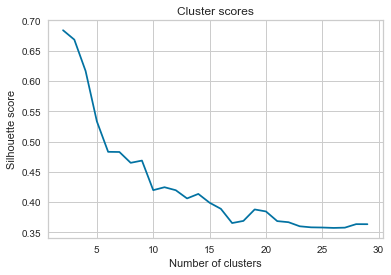

In [17]:
def numclusters(n,step):
    srs = [clusterify(i, False) for i in range(2,n,step)]
    plt.plot(range(2,n,step), srs)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title('Cluster scores')
    plt.show()
numclusters(30, 1)

## AdFuller test

In [18]:
def clusterLooper(func, num_clusters=6):
    """Get the cluster data and loop through it applying the passed function"""
    X = clusterify(num_clusters, show_output=False, return_df=True)
    X = cases_df.merge(X, how='inner', left_on='areaCode', right_on='LAD20CD')
    # split by cluster 
    for i in range(num_clusters):
        mini_df = X[X['cluster'] == i].copy()
        mini_df['date'] = pd.to_datetime(mini_df['date'])
        mini_df = mini_df.groupby('date').sum()
        mini_df = mini_df[['newCasesByPublishDate', 'newDeaths28DaysByDeathDate', 'newPeopleVaccinatedFirstDoseByVaccinationDate', 'newPeopleVaccinatedSecondDoseByVaccinationDate']]
        func(i, mini_df)

def addfullerApplier(cluster, df):
    """Run the adfuller test on each cluster"""
    res = adfuller(df['newCasesByPublishDate'])
    plt.plot(df.index, df['newCasesByPublishDate'], label=str(cluster))
    plt.xlabel('Date')
    plt.ylabel('New Cases')

    # Code very vaguely from data-camp
    print('cluster:', cluster, 'Statistic:', res[0], 'p-value:', res[1])

cluster: 0 Statistic: 0.8488250195981304 p-value: 0.9923847828285471
cluster: 1 Statistic: 0.06578672878085082 p-value: 0.9636460567671419
cluster: 2 Statistic: -0.9328494039449263 p-value: 0.7769622838363393
cluster: 3 Statistic: 1.168346708899054 p-value: 0.9957597238368124
cluster: 4 Statistic: 0.528305785954572 p-value: 0.9857085041020311
cluster: 5 Statistic: 0.7202257324234088 p-value: 0.9902329849371048


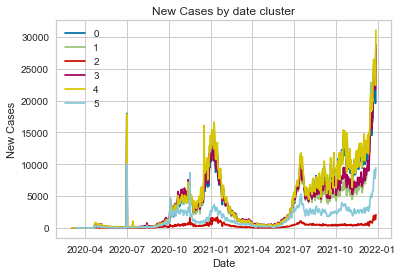

In [19]:
clusterLooper(addfullerApplier)
plt.legend()
plt.title('New Cases by date cluster')
plt.show()

<Figure size 432x288 with 0 Axes>

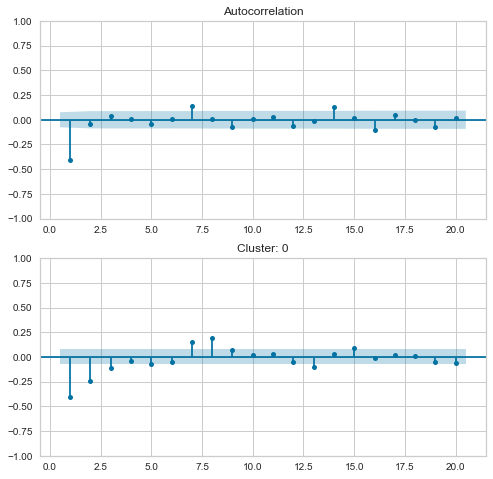

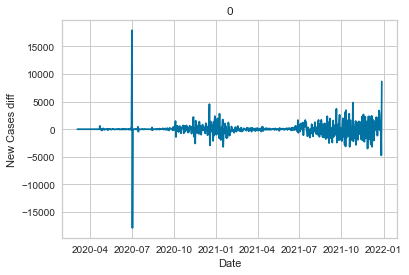

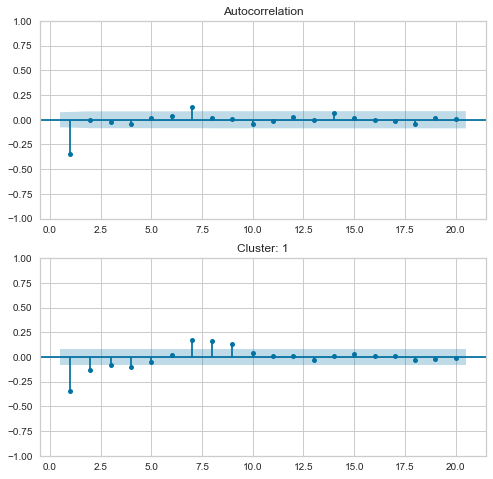

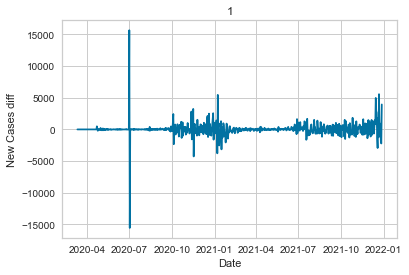

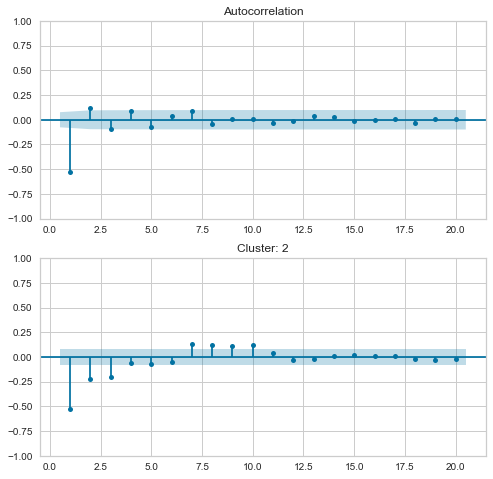

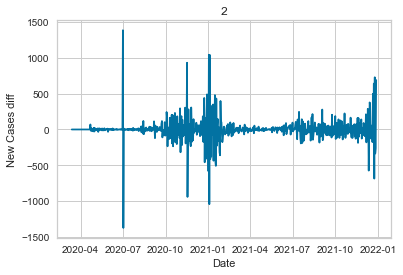

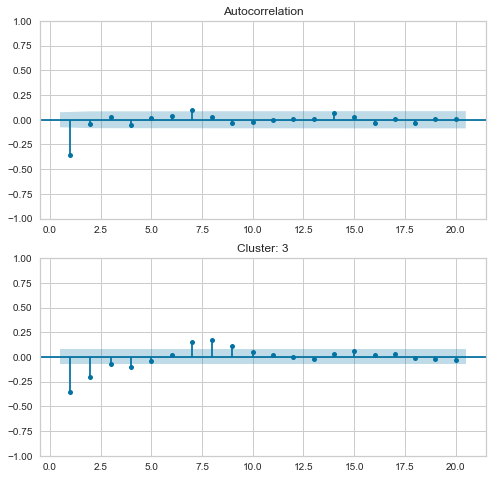

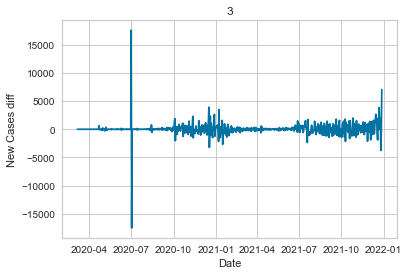

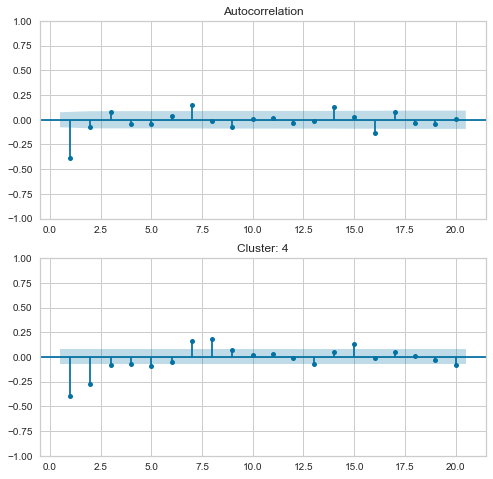

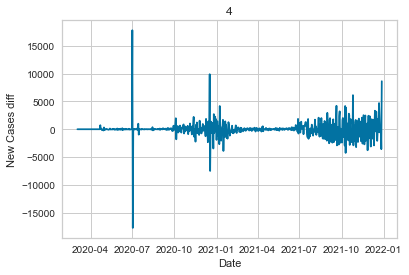

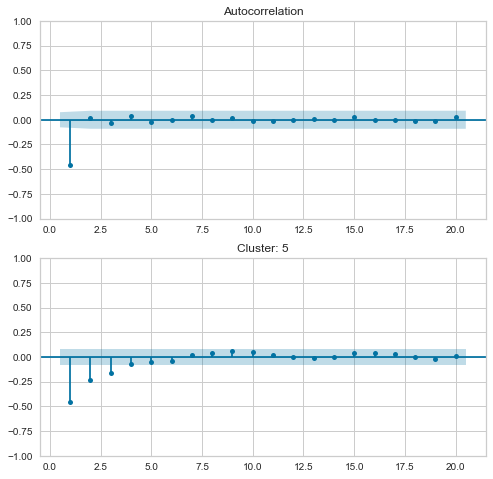

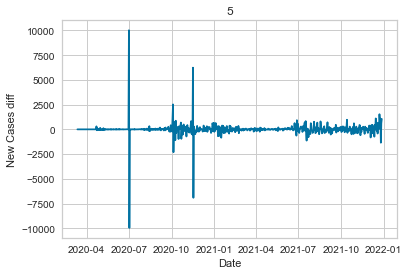

In [20]:
def acfAndPacfApplier(cluster, df):
    """Apply the plot_acf and plot_pacf graphs"""
    # Using some code from datacamp
    fig, ax = plt.subplots(2, 1, figsize=(8,8))
    d = df['newCasesByPublishDate'].diff().dropna()
    plot_acf(d, lags=20, zero=False, ax=ax[0])
    plot_pacf(d, lags=20, zero=False, ax=ax[1], method='ywm')
    plt.title('Cluster: ' + str(cluster))
    plt.show()
    
    plt.plot(d.index, d)
    plt.title(str(cluster))
    plt.xlabel('Date')
    plt.ylabel('New Cases diff')
    plt.show()
clusterLooper(acfAndPacfApplier)

In [21]:
def check_auto_arima(cluster, df):
    """Uses pmdarima to scan for the best settings"""
    # test
    results = pm.auto_arima(df['newCasesByPublishDate'], trace=True, seasonal=True)
    print(cluster)
    print(results.summary())
clusterLooper(check_auto_arima)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11353.870, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11527.173, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11402.422, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11348.943, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11525.783, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11350.663, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11350.614, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=11349.994, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 4.050 seconds
0
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  666
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -5671.471
Date:                Fri, 07 Jan 2022   AIC 

<Figure size 432x288 with 0 Axes>

## Make ARIMA models

In [22]:
r_df = pd.read_csv('rRate.csv')
#r_df['date'] = pd.to_datetime(r_df['date'])
r_df['date'] = pd.to_datetime(r_df['date'], format='%d/%m/%Y')
r_df.drop('Unnamed: 2', inplace=True, axis=1)
r_df

,date,r
0,2020-03-11,0.8
1,2020-03-12,0.8
2,2020-03-13,0.8
3,2020-03-14,0.8
4,2020-03-15,0.8
...,...,...
653,2021-12-24,1.1
654,2021-12-25,1.1
655,2021-12-26,1.1
656,2021-12-27,1.1


                                 SARIMAX Results                                 
Dep. Variable:     newCasesByPublishDate   No. Observations:                  580
Model:                  SARIMAX(0, 1, 1)   Log Likelihood               -4590.582
Date:                   Fri, 07 Jan 2022   AIC                           9187.164
Time:                           12:15:32   BIC                           9200.248
Sample:                       03-03-2020   HQIC                          9192.266
                            - 10-03-2021                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.3867     19.517      0.993      0.321     -18.866      57.640
ma.L1         -0.3323      0.025    -13.072      0.000      -0.382      -0.282
sigma2      4.549e+05   1.19

<Figure size 432x288 with 0 Axes>

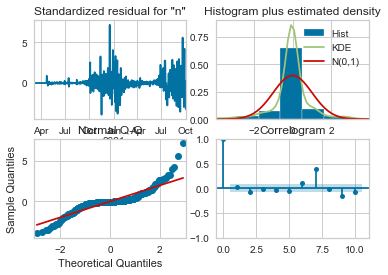

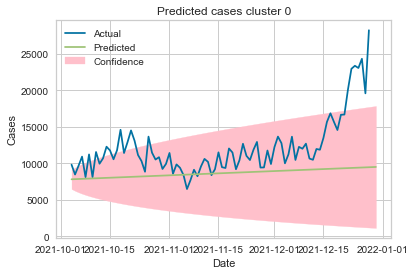

                                 SARIMAX Results                                 
Dep. Variable:     newCasesByPublishDate   No. Observations:                  573
Model:                  SARIMAX(0, 1, 1)   Log Likelihood               -4507.674
Date:                   Fri, 07 Jan 2022   AIC                           9021.349
Time:                           12:15:33   BIC                           9034.396
Sample:                       03-10-2020   HQIC                          9026.439
                            - 10-03-2021                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     11.3468     18.797      0.604      0.546     -25.495      48.189
ma.L1         -0.3127      0.018    -17.414      0.000      -0.348      -0.278
sigma2      4.129e+05   1.02

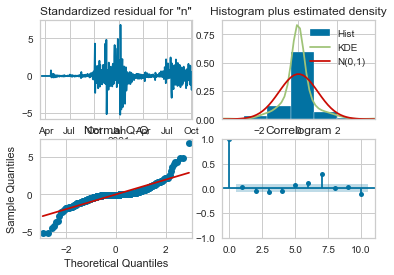

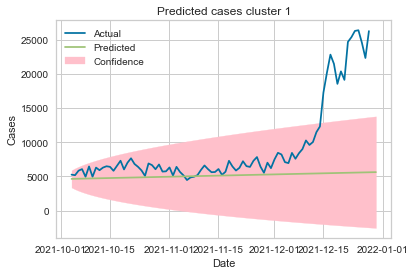

                                 SARIMAX Results                                 
Dep. Variable:     newCasesByPublishDate   No. Observations:                  571
Model:                  SARIMAX(0, 1, 1)   Log Likelihood               -3507.235
Date:                   Fri, 07 Jan 2022   AIC                           7020.470
Time:                           12:15:34   BIC                           7033.507
Sample:                       03-12-2020   HQIC                          7025.557
                            - 10-03-2021                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7275      1.954      0.372      0.710      -3.103       4.558
ma.L1         -0.6309      0.016    -39.189      0.000      -0.662      -0.599
sigma2      1.293e+04    244

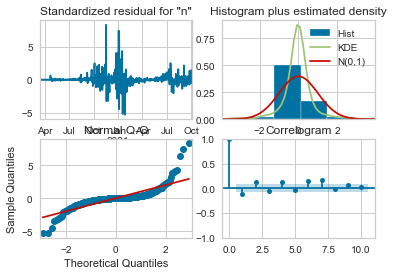

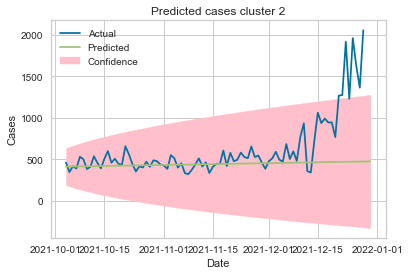

                                 SARIMAX Results                                 
Dep. Variable:     newCasesByPublishDate   No. Observations:                  578
Model:                  SARIMAX(0, 1, 1)   Log Likelihood               -4509.514
Date:                   Fri, 07 Jan 2022   AIC                           9025.028
Time:                           12:15:35   BIC                           9038.102
Sample:                       03-05-2020   HQIC                          9030.126
                            - 10-03-2021                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.9308     19.827      0.652      0.514     -25.929      51.791
ma.L1         -0.2608      0.020    -12.956      0.000      -0.300      -0.221
sigma2      3.637e+05   9873

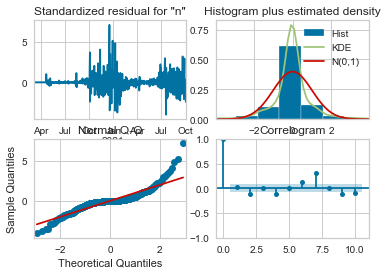

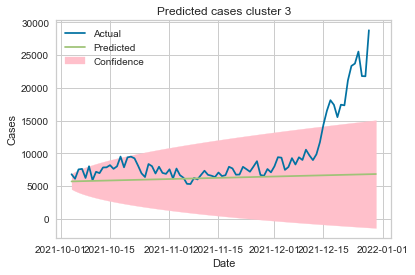

                                 SARIMAX Results                                 
Dep. Variable:     newCasesByPublishDate   No. Observations:                  581
Model:                  SARIMAX(0, 1, 1)   Log Likelihood               -4756.799
Date:                   Fri, 07 Jan 2022   AIC                           9519.599
Time:                           12:15:36   BIC                           9532.688
Sample:                       03-02-2020   HQIC                          9524.702
                            - 10-03-2021                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.4942     23.943      0.898      0.369     -25.433      68.421
ma.L1         -0.4399      0.020    -22.348      0.000      -0.478      -0.401
sigma2      7.976e+05   1.24

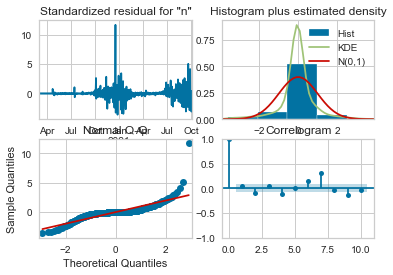

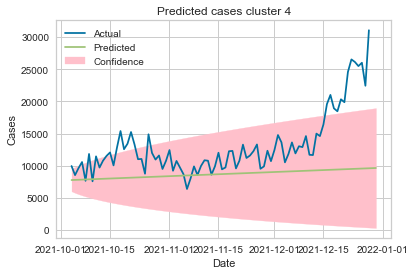

                                 SARIMAX Results                                 
Dep. Variable:     newCasesByPublishDate   No. Observations:                  572
Model:                  SARIMAX(0, 1, 1)   Log Likelihood               -4256.176
Date:                   Fri, 07 Jan 2022   AIC                           8518.352
Time:                           12:15:37   BIC                           8531.395
Sample:                       03-11-2020   HQIC                          8523.441
                            - 10-03-2021                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.8661     11.337      0.341      0.733     -18.354      26.086
ma.L1         -0.5606      0.010    -53.789      0.000      -0.581      -0.540
sigma2       1.76e+05   2193

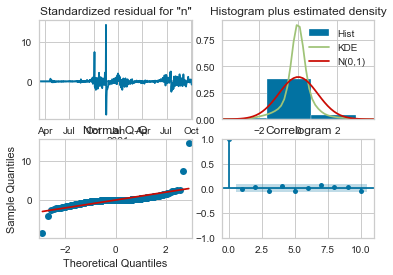

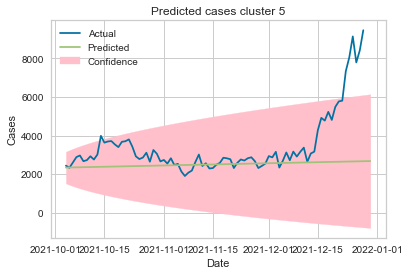

In [23]:
IMA_models = {}
def arima_maker(cluster, df):
    """This splits the data into testing and training data and fits an ARIMA model to it
    make the split in Oct 21"""
    # Join r data
    '''df['Date'] = df.index
    df = df.merge(r_df, how='outer', left_on='Date', right_on='date')
    df.drop('date', axis=1, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)'''

    # Split to train and testing
    train_df = df.loc[:'2021-10-03']
    train_df.loc['2020-07-01']['newCasesByPublishDate'] = 1
    test_df = df.loc['2021-10-04':]
    train_df.index = pd.DatetimeIndex(train_df.index.values, freq=train_df.index.inferred_freq)
    
    #train_df['week'] = pd.PeriodIndex(train_df.index, freq='w')
    #train_df['day'] = train_df['week'].apply(lambda x: str(x).split('/')[0])
    #train_df['day'] = pd.to_datetime(train_df['day'])
    #train_df = train_df.groupby('day').sum()
    #train_df.index = pd.DatetimeIndex(train_df.index.values, freq='D')

    #test_df['week'] = pd.PeriodIndex(test_df.index, freq='w')
    #test_df['day'] = test_df['week'].apply(lambda x: str(x).split('/')[0])
    #test_df['day'] = pd.to_datetime(test_df['day'])
    #test_df = test_df.groupby('day').sum()

    # make and train model
    # code vaguely from DataCamp
    # train_df['r'] = train_df['r'].fillna(0.8)
    # mdl = SARIMAX(train_df['newCasesByPublishDate'], order=(0,1,1), trend='c', exog=train_df['r'])
    mdl = SARIMAX(train_df['newCasesByPublishDate'], order=(0,1,1), trend='c')
    results = mdl.fit()
    results.plot_diagnostics()
    print(results.summary())
    plt.show()

    # Predict the next 88 results
    # forecast = results.get_forecast(steps=86, exog=test_df['r'])
    forecast = results.get_forecast(steps=88)
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()

    # draw the predicted data
    plt.plot(test_df.index, test_df['newCasesByPublishDate'], label='Actual')
    plt.plot(forecast_mean.index, forecast_mean, label='Predicted')
    plt.fill_between(forecast_mean.index, conf_int['lower newCasesByPublishDate'], conf_int['upper newCasesByPublishDate'], label='Confidence', color='pink')
    plt.title('Predicted cases cluster ' + str(cluster))
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()

clusterLooper(arima_maker)

score: -2.882420849055916


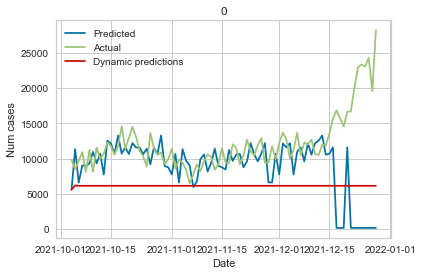

score: 0.6134637746376381


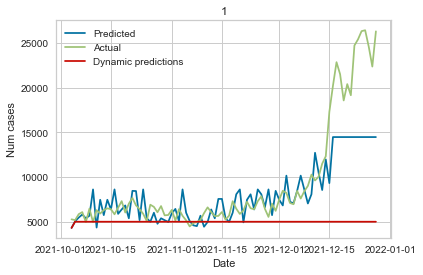

score: 0.1248503872001917


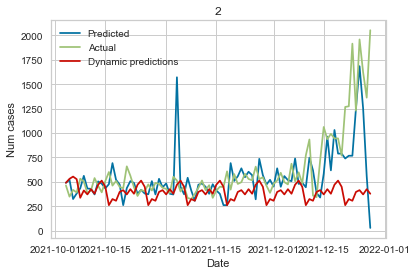

score: -1.4186726594605479


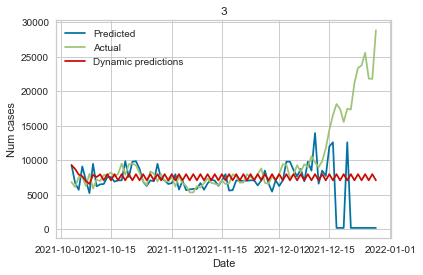

score: -2.5744898190948913


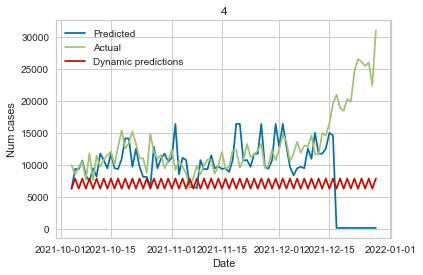

score: -0.24367720865183018


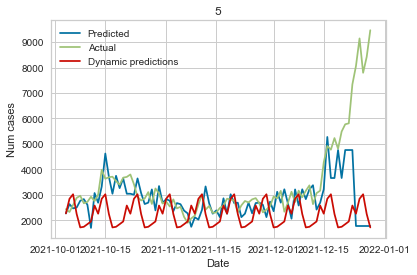

In [24]:
def svr_maker(cluster, df):
    """This splits the data into testing and training data and fits an SVR model to it
    make the split in Oct 21"""
    # sort out df
    df = df[['newCasesByPublishDate']]
    df['lastDayCases'] = df['newCasesByPublishDate'].shift(1)

    # Split to train and testing
    train_df = df.loc[:'2021-10-03']
    train_df.loc['2020-07-01']['newCasesByPublishDate'] = 1
    test_df = df.loc['2021-10-04':]
    train_df.index = pd.DatetimeIndex(train_df.index.values, freq=train_df.index.inferred_freq)
    
    # make svr model
    mdl = Pipeline([
        ('xg', xgb.XGBRegressor(random_state=42))
    ])

    # split data
    train_df.dropna(inplace=True)
    y_train = train_df['newCasesByPublishDate']
    train_df.drop('newCasesByPublishDate', inplace=True, axis=1)
    y_test = test_df['newCasesByPublishDate']
    test_df.drop('newCasesByPublishDate', inplace=True, axis=1)

    # train model
    mdl.fit(train_df, y_train)

    # test model
    print("score:", mdl.score(test_df, y_test))
    preds = mdl.predict(test_df)
    plt.plot(test_df.index, preds, label='Predicted')
    plt.plot(test_df.index, y_test, label='Actual')

    last_pred = y_train[-1]
    start_date = datetime.datetime(2021, 10, 4)
    predictions = []
    for i in range(86):
        start_date = start_date + datetime.timedelta(days=i)
        X = pd.DataFrame.from_dict({'date': [start_date], 'lastDayCases': [last_pred]})
        X.set_index('date', inplace=True)
        pred = mdl.predict(X)
        last_pred = pred[0]
        predictions.append(last_pred)
    plt.plot(test_df.index, predictions, label='Dynamic predictions')

    plt.legend()
    plt.title(str(cluster))
    plt.xlabel('Date')
    plt.ylabel('Num cases')
    plt.show()
    

clusterLooper(svr_maker)

## 3D plot

In [25]:
#@widgets.interact(month=widgets.IntSlider(min=1, max=12, step=1), year=widgets.IntSlider(min=2020, max=2021, step=1))
#def filtercasemap(month, year):
if False:
    cases_la_map = df.merge(cases_df, left_on='LAD20CD', right_on='areaCode')
    cases_la_map.dropna(subset=['00_59', 'newCasesByPublishDate_y'], inplace=True)
    '''cases_la_map['n_days'] = cases_la_map.apply(lambda x: (x['date'] - datetime.datetime(2020, 4, 22)).days, axis=1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #ax.scatter(cases_la_map['LONG'], cases_la_map['LAT'], zs=cases_la_map['newCasesByPublishDate'])
    ax.scatter(cases_la_map['LONG'], cases_la_map['LAT'], zs=cases_la_map['n_days'], c=cases_la_map['newCasesByPublishDate_y'], cmap='RdBu', alpha=0.8)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()'''
    my = {2020: [m for m in range(4,13)], 2021: [m for m in range(1,13)]}
    for year in my.keys():
        for month in my[year]:
            cases_la_map2 = cases_la_map[(cases_la_map.date.dt.month == month) & (cases_la_map.date.dt.year == year)].copy()
            cases_la_map2.plot(column='newCasesByPublishDate_y', cmap='RdBu')
            plt.title('Year ' + str(year) + ' month ' + str(month))
            plt.show()

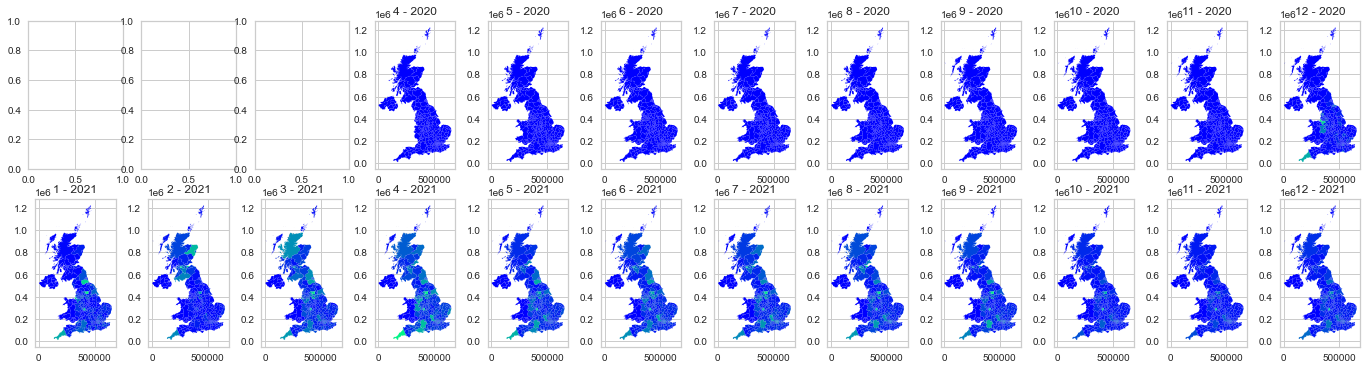

In [31]:
# group cases into month and year
cases_df['mnth'] = cases_df['date'].dt.month
cases_df['year'] = cases_df['date'].dt.year
cases_by_month = cases_df.groupby(['areaCode', 'year', 'mnth']).sum().fillna(0).reset_index()

# merge the buckinghamshire cases and drop them
cases_by_month_bucks = cases_by_month[cases_by_month.areaCode.isin(['E07000004', 'E07000005', 'E07000006', 'E07000007'])]
cases_by_month_bucks = cases_by_month_bucks.groupby(['year', 'mnth']).sum().reset_index()
cases_by_month_bucks['areaCode'] = 'E06000060'
cases_by_month = cases_by_month.append(cases_by_month_bucks)
cases_by_month = cases_by_month[~cases_by_month['areaCode'].isin(['E07000004', 'E07000005', 'E07000006', 'E07000007'])]

# Merge the geo data
cases_la_by_month_map = df.merge(cases_by_month, left_on='LAD20CD', right_on='areaCode')

# Draw the maps
my = {2020: [m for m in range(4,13)], 2021: [m for m in range(1,13)]}
fig, ax = plt.subplots(nrows=2, ncols=12, figsize=(24, 6))
for yid, year in enumerate(my.keys()):
    for month in my[year]:
        cases_la_by_month_map2 = cases_la_by_month_map[(cases_la_by_month_map.mnth == month) & (cases_la_by_month_map.year== year)].copy()
        cases_la_by_month_map2.plot(column='newCasesByPublishDate_y', cmap='winter', ax=ax[yid][month-1])
        ax[yid][month-1].set_title(str(month) + ' - ' + str(year))
        # plt.title('Year ' + str(year) + ' month ' + str(month))
plt.show()